# Using rapidfuzz to extract affiliatuons from RES

First the JSON output file from tezseract is read in and made into a useable dataframe

In [33]:
#Importing the libraries
import json
import pandas as pd
from rapidfuzz import process
import requests

# Load input files from github
#tesseract_input = requests.get('https://raw.githubusercontent.com/Matt970204/Affiliations_V2/main/1_Input%20files%20and%20processing%20input%20files/1_1_Input%20files/Tesseract%20affiliation%20output/AER/AER_aff_output_1971_2010.json')
#json_data = tesseract_input.json()

# Import JSON file
f = open('/Users/MattJohnson/Desktop/Affiliations/1_Input files and processing input files/1_1_Input files/Tesseract affiliation output/AER/AER_aff_output_1971_2010.json')
#f = open('/Users/MattJohnson/Desktop/Affiliations/1_Input files and processing input files/1_1_Input files/Tesseract affiliation output/AER/AER_aff_output_1950_N.json')
json_data = json.load(f)

# Define Journal and Dataframe
Journal_Name = 'AER'
Reference_Data_List = []

# Extract Json Data into dataframe
for key1, value1 in json_data.items():
    Article_ID = key1
    content_type = value1["content_type"]
    author_list = value1["authors"]
    authorsNo = len(author_list)
    stable_url = value1["stable_url"]
    for key2 in value1["affiliations"]:
        Ref_type = key2
        if key2 == "found":
            ref_string = value1["affiliations"][key2]

    Reference_Data_List.append({'Journal_Name' : Journal_Name,
    'Authors_count' : authorsNo, 
    'Article_ID' : Article_ID, 'content_type' : content_type,
    'stable_url' : stable_url, 
    'Ref_type': Ref_type,  'ref_string':ref_string })


AER_aff_ref_output_1940_2010 = pd.DataFrame.from_records(Reference_Data_List)
AER_aff_ref_output_1940_2010.to_excel('/Users/MattJohnson/Desktop/Affiliations/2_Extracting affilitations/2_Fuzzy matching/Working files/AER_aff_ref_output_1940_2010.xlsx')        

Next the Unique list of universities is read in, this is used as a database to check the affiliton string against using rapidfuzz. 

In [34]:
# Load in the list of unique Universites from github stored in 2_fuzzy matching
#affs = pd.read_excel("https://raw.githubusercontent.com/Matt970204/Affiliations_V2/main/2_Extracting%20affilitations/2_Fuzzy%20matching/University%20list/Unique%20Universities.xlsx")


affs = pd.read_excel('/Users/MattJohnson/Desktop/Affiliations/2_Extracting affilitations/2_Fuzzy matching/University list/Unique Universities.xlsx')
print(affs.shape)

for i in range(len(affs)):
    #Replaceing title case and stripping leading space
    affs.iat[i,0] = affs.iat[i,0].strip().title()
    #affs.iat[i,0] = affs.iat[i,0].strip().upper()

Affiliation_choices = affs['Affilliation'].values.tolist()

#testdata = RES_1940_2010.loc[0:20].reset_index(drop = True)
testdata = AER_aff_ref_output_1940_2010

for i in range(len(testdata)):
    #Replaceing title case and stripping leading space
    testdata.iat[i,6] = testdata.iat[i,6].strip().title()
    #testdata.iat[i,6] = testdata.iat[i,6].strip().upper()

print(affs.head())


(849, 14)
        Affilliation Unnamed: 1   Len            Unnamed: 3 Unnamed: 4  \
0    Yale University        NaN   4.0                  Yale        NaN   
1          Cambridge        NaN   NaN                   NaN        NaN   
2            Harvard        NaN   NaN                   NaN        NaN   
3             Oxford        NaN   NaN                   NaN        NaN   
4  Oxford University        NaN  17.0  University of Oxford    In list   

   Unnamed: 5  Unnamed: 6  Unnamed: 7 Unnamed: 8 Unnamed: 9  Unnamed: 10  \
0         NaN         NaN         NaN    Oxford    Colleges          NaN   
1         NaN         NaN         NaN        NaN        NaN          NaN   
2         NaN         NaN         NaN        NaN        NaN          NaN   
3         NaN         NaN         NaN        NaN        NaN          NaN   
4         NaN         NaN         NaN       Yale   Colleges          NaN   

  Unnamed: 11 Unnamed: 12 Unnamed: 13  
0         NaN         NaN         NaN  
1       

In [35]:
#Reading in the master file and correctly formatting the article ID to match back onto the meltef file

#Load in master from Github
#AER_master = pd.read_excel("https://raw.githubusercontent.com/Matt970204/Affiliations_V2/main/1_Input%20files%20and%20processing%20input%20files/1_1_Input%20files/Master%20lists/Processed/AER_processed.xlsx")

#Local store of AER_master
AER_master = pd.read_excel('/Users/MattJohnson/Desktop/Affiliations/1_Input files and processing input files/1_1_Input files/Master lists/Processed/AER_processed.xlsx')
for i in range(len(AER_master)):
    AER_master.loc[i,['Article_ID']] = AER_master.loc[i,['stable_url']].to_string().rsplit('/',1)[-1]

AER_master_condenced  = AER_master[['Article_ID','year']]
AER_master_condenced['year'] = AER_master_condenced['year'].astype('int')
AER_master_condenced.head()

In [ ]:
# MErging the msterfile onto the new melted file to get additional data
testdata_merged = testdata.merge(AER_master_condenced, how = 'left', on = 'Article_ID')
testdata_merged = testdata_merged.sort_values(by=['year'])
testdata = testdata_merged.reset_index(drop = True)

# Excel output to get an overview of the data
testdata.head
testdata.to_excel('/Users/MattJohnson/Desktop/Affiliations/2_Extracting affilitations/2_Fuzzy matching/AER/Test files/AER_aff_ref_output_1940_2010_affs_out initial data.xlsx') 

In [ ]:
list(testdata.columns.values)
testdata = testdata[['Journal_Name',
 'Authors_count',
 'Article_ID',
 'content_type',
 'stable_url',
 'Ref_type',
 'ref_string',
  'year',]]
list(testdata.columns.values)

['Journal_Name',
 'Authors_count',
 'Article_ID',
 'content_type',
 'stable_url',
 'Ref_type',
 'ref_string',
 'year']

Next the test data is split line by line and parsed through the fuzzy matching library rapid fuzz.  Using the process.extract function a list of variables from a data frame being the unique universities is checked to see if there is a match in the input line from tesseract.

In [ ]:
# For loop to iterate through lines in the input data and check to see if this exists in the created data base. 
# If it exists it is appended to a dataframe as the next affiliton for that paper
import time as t
for i in range(len(testdata)):
#for i in range(61,62):

    if (testdata.iloc[i]['year']) >= 1971:
        import re
        str1 = testdata.iloc[i]['ref_string']
        splitorg = str1.split('\n\n')
        split2 = splitorg[0].split('.')
        split2clean = re.sub(r"(\-\n)","", split2[0])
        split3clean = re.sub(r"(\*)|(\")|(\,)|(Research Associate)|(Professor Of Economics)|(Professor Department Of Economics)|(Visiting Assistant Professor)|(Associate Professor)|(Assistant)|(Professor)|(And)","", split2clean)
        #split3clean = re.sub(r"(\*)|(\")|(\,)|(RESEARCH ASSOCIATE)|(PROFESSOR OF ECONOMICS)|(PROFESSOR DEPARTMENT OF ECONOMICS)|(VISITIG ASSISTANT PROFESSOR)|(ASSOCIATE PROFESSOR)|(ASSISTANT)|(PROFESSOR)|(AND)","", split2clean)
        split4clean = re.sub(r"(\n)"," ", split3clean)
        split4clean = split4clean.strip()
        
    split = split4clean
    split_len = len(split)
        #print(split_len)
#Testing    


    errors = ["Re", "s University", "Research", "University Of", "Un", "Re:"]
    #errors = ["RE", "S UNIVERSITY", "RESEARCH", "UNIVERSITY OF", "UN", "RE:"]
    if split in errors:
        split = ""
    #print(string)

    #print(string)
   # print(split_len)

    affiliations = []
    count_no_aff = 0
    #print(split_len)

    affiliations = process.extract(split,Affiliation_choices, limit= 10, score_cutoff= 90)
    
    print(affiliations)
    print("Length = " , len(affiliations), ", Number = ",i)
    
    #Testing
    print(split)
    #print(affiliations[0][0])
    #t.sleep(4)

    testdata.loc[i,['string']] = split
    #print("STRING!!!")
    #print(testdata.loc[i,['string']])
    #t.sleep(4)

    if len(affiliations) == 0:
        testdata.loc[i,['Missing aff']] = "Missing"
        testdata.loc[i,['No of Affs']] = len(affiliations)
    elif len(affiliations) == 1:
        testdata.loc[i,['aff1']] = affiliations[0][0]
        testdata.loc[i,['aff1_Picked_Up']] = Affiliation_choices[affiliations[0][2]]
        testdata.loc[i,['aff1_Score']] = affiliations[0][1]
        testdata.loc[i,['Missing aff']] = "Contains"
        testdata.loc[i,['No of Affs']] = len(affiliations)
    elif len(affiliations) == 2:
        testdata.loc[i,['aff1']] = affiliations[0][0]
        testdata.loc[i,['aff1_Picked_Up']] = Affiliation_choices[affiliations[0][2]]
        testdata.loc[i,['aff1_Score']] = affiliations[0][1]
        testdata.loc[i,['aff2']] = affiliations[1][0]
        testdata.loc[i,['aff2_Picked_Up']] = Affiliation_choices[affiliations[1][2]]
        testdata.loc[i,['aff2_Score']] = affiliations[1][1]
        testdata.loc[i,['Missing aff']] = "Contains"
        testdata.loc[i,['No of Affs']] = len(affiliations)
    elif len(affiliations) == 3:
        testdata.loc[i,['aff1']] = affiliations[0][0]
        testdata.loc[i,['aff1_Picked_Up']] = Affiliation_choices[affiliations[0][2]]
        testdata.loc[i,['aff1_Score']] = affiliations[0][1]
        testdata.loc[i,['aff2']] = affiliations[1][0]
        testdata.loc[i,['aff2_Picked_Up']] = Affiliation_choices[affiliations[1][2]]
        testdata.loc[i,['aff2_Score']] = affiliations[1][1]
        testdata.loc[i,['aff3']] = affiliations[2][0]
        testdata.loc[i,['aff3_Picked_Up']] = Affiliation_choices[affiliations[2][2]]
        testdata.loc[i,['aff3_Score']] = affiliations[2][1]
        testdata.loc[i,['Missing aff']] = "Contains"
        testdata.loc[i,['No of Affs']] = len(affiliations)
    elif len(affiliations) == 4:
        testdata.loc[i,['aff1']] = affiliations[0][0]
        testdata.loc[i,['aff1_Picked_Up']] = Affiliation_choices[affiliations[0][2]]
        testdata.loc[i,['aff1_Score']] = affiliations[0][1]
        testdata.loc[i,['aff2']] = affiliations[1][0]
        testdata.loc[i,['aff2_Picked_Up']] = Affiliation_choices[affiliations[1][2]]
        testdata.loc[i,['aff2_Score']] = affiliations[1][1]
        testdata.loc[i,['aff3']] = affiliations[2][0]
        testdata.loc[i,['aff3_Picked_Up']] = Affiliation_choices[affiliations[2][2]]
        testdata.loc[i,['aff3_Score']] = affiliations[2][1]
        testdata.loc[i,['aff4']] = affiliations[3][0]
        testdata.loc[i,['aff4_Picked_Up']] = Affiliation_choices[affiliations[3][2]]
        testdata.loc[i,['aff4_Score']] = affiliations[3][1]
        testdata.loc[i,['Missing aff']] = "Contains"
        testdata.loc[i,['No of Affs']] = len(affiliations)
    elif len(affiliations) == 5:
        testdata.loc[i,['aff1']] = affiliations[0][0]
        testdata.loc[i,['aff1_Picked_Up']] = Affiliation_choices[affiliations[0][2]]
        testdata.loc[i,['aff1_Score']] = affiliations[0][1]
        testdata.loc[i,['aff2']] = affiliations[1][0]
        testdata.loc[i,['aff2_Picked_Up']] = Affiliation_choices[affiliations[1][2]]
        testdata.loc[i,['aff2_Score']] = affiliations[1][1]
        testdata.loc[i,['aff3']] = affiliations[2][0]
        testdata.loc[i,['aff3_Picked_Up']] = Affiliation_choices[affiliations[2][2]]
        testdata.loc[i,['aff3_Score']] = affiliations[2][1]
        testdata.loc[i,['aff4']] = affiliations[3][0]
        testdata.loc[i,['aff4_Picked_Up']] = Affiliation_choices[affiliations[3][2]]
        testdata.loc[i,['aff4_Score']] = affiliations[3][1]
        testdata.loc[i,['aff5']] = affiliations[4][0]
        testdata.loc[i,['aff5_Picked_Up']] = Affiliation_choices[affiliations[4][2]]
        testdata.loc[i,['aff5_Score']] = affiliations[4][1]
        testdata.loc[i,['Missing aff']] = "Contains"
        testdata.loc[i,['No of Affs']] = len(affiliations)
        print(affiliations)
    elif len(affiliations) == 6:
        testdata.loc[i,['aff1']] = affiliations[0][0]
        testdata.loc[i,['aff1_Picked_Up']] = Affiliation_choices[affiliations[0][2]]
        testdata.loc[i,['aff1_Score']] = affiliations[0][1]
        testdata.loc[i,['aff2']] = affiliations[1][0]
        testdata.loc[i,['aff2_Picked_Up']] = Affiliation_choices[affiliations[1][2]]
        testdata.loc[i,['aff2_Score']] = affiliations[1][1]
        testdata.loc[i,['aff3']] = affiliations[2][0]
        testdata.loc[i,['aff3_Picked_Up']] = Affiliation_choices[affiliations[2][2]]
        testdata.loc[i,['aff3_Score']] = affiliations[2][1]
        testdata.loc[i,['aff4']] = affiliations[3][0]
        testdata.loc[i,['aff4_Picked_Up']] = Affiliation_choices[affiliations[3][2]]
        testdata.loc[i,['aff4_Score']] = affiliations[3][1]
        testdata.loc[i,['aff5']] = affiliations[4][0]
        testdata.loc[i,['aff5_Picked_Up']] = Affiliation_choices[affiliations[4][2]]
        testdata.loc[i,['aff5_Score']] = affiliations[4][1]
        testdata.loc[i,['aff6']] = affiliations[5][0]
        testdata.loc[i,['aff6_Picked_Up']] = Affiliation_choices[affiliations[5][2]]
        testdata.loc[i,['aff6_Score']] = affiliations[5][1]
        testdata.loc[i,['Missing aff']] = "Contains"
        testdata.loc[i,['No of Affs']] = len(affiliations)
    elif len(affiliations) == 7:
        testdata.loc[i,['aff1']] = affiliations[0][0]
        testdata.loc[i,['aff1_Picked_Up']] = Affiliation_choices[affiliations[0][2]]
        testdata.loc[i,['aff1_Score']] = affiliations[0][1]
        testdata.loc[i,['aff2']] = affiliations[1][0]
        testdata.loc[i,['aff2_Picked_Up']] = Affiliation_choices[affiliations[1][2]]
        testdata.loc[i,['aff2_Score']] = affiliations[1][1]
        testdata.loc[i,['aff3']] = affiliations[2][0]
        testdata.loc[i,['aff3_Picked_Up']] = Affiliation_choices[affiliations[2][2]]
        testdata.loc[i,['aff3_Score']] = affiliations[2][1]
        testdata.loc[i,['aff4']] = affiliations[3][0]
        testdata.loc[i,['aff4_Picked_Up']] = Affiliation_choices[affiliations[3][2]]
        testdata.loc[i,['aff4_Score']] = affiliations[3][1]
        testdata.loc[i,['aff5']] = affiliations[4][0]
        testdata.loc[i,['aff5_Picked_Up']] = Affiliation_choices[affiliations[4][2]]
        testdata.loc[i,['aff5_Score']] = affiliations[4][1]
        testdata.loc[i,['aff6']] = affiliations[5][0]
        testdata.loc[i,['aff6_Picked_Up']] = Affiliation_choices[affiliations[5][2]]
        testdata.loc[i,['aff6_Score']] = affiliations[5][1]
        testdata.loc[i,['aff7']] = affiliations[6][0]
        testdata.loc[i,['aff7_Picked_Up']] = Affiliation_choices[affiliations[6][2]]
        testdata.loc[i,['aff7_Score']] = affiliations[6][1]
        testdata.loc[i,['Missing aff']] = "Contains"
        testdata.loc[i,['No of Affs']] = len(affiliations)
    elif len(affiliations) == 8:
        testdata.loc[i,['aff1']] = affiliations[0][0]
        testdata.loc[i,['aff1_Picked_Up']] = Affiliation_choices[affiliations[0][2]]
        testdata.loc[i,['aff1_Score']] = affiliations[0][1]
        testdata.loc[i,['aff2']] = affiliations[1][0]
        testdata.loc[i,['aff2_Picked_Up']] = Affiliation_choices[affiliations[1][2]]
        testdata.loc[i,['aff2_Score']] = affiliations[1][1]
        testdata.loc[i,['aff3']] = affiliations[2][0]
        testdata.loc[i,['aff3_Picked_Up']] = Affiliation_choices[affiliations[2][2]]
        testdata.loc[i,['aff3_Score']] = affiliations[2][1]
        testdata.loc[i,['aff4']] = affiliations[3][0]
        testdata.loc[i,['aff4_Picked_Up']] = Affiliation_choices[affiliations[3][2]]
        testdata.loc[i,['aff4_Score']] = affiliations[3][1]
        testdata.loc[i,['aff5']] = affiliations[4][0]
        testdata.loc[i,['aff5_Picked_Up']] = Affiliation_choices[affiliations[4][2]]
        testdata.loc[i,['aff5_Score']] = affiliations[4][1]
        testdata.loc[i,['aff6']] = affiliations[5][0]
        testdata.loc[i,['aff6_Picked_Up']] = Affiliation_choices[affiliations[5][2]]
        testdata.loc[i,['aff6_Score']] = affiliations[5][1]
        testdata.loc[i,['aff7']] = affiliations[6][0]
        testdata.loc[i,['aff7_Picked_Up']] = Affiliation_choices[affiliations[6][2]]
        testdata.loc[i,['aff7_Score']] = affiliations[6][1]
        testdata.loc[i,['aff8']] = affiliations[7][0]
        testdata.loc[i,['aff8_Picked_Up']] = Affiliation_choices[affiliations[7][2]]
        testdata.loc[i,['aff8_Score']] = affiliations[7][1]
        testdata.loc[i,['Missing aff']] = "Contains"
        testdata.loc[i,['No of Affs']] = len(affiliations)
    elif len(affiliations) == 9:
        testdata.loc[i,['aff1']] = affiliations[0][0]
        testdata.loc[i,['aff1_Picked_Up']] = Affiliation_choices[affiliations[0][2]]
        testdata.loc[i,['aff1_Score']] = affiliations[0][1]
        testdata.loc[i,['aff2']] = affiliations[1][0]
        testdata.loc[i,['aff2_Picked_Up']] = Affiliation_choices[affiliations[1][2]]
        testdata.loc[i,['aff2_Score']] = affiliations[1][1]
        testdata.loc[i,['aff3']] = affiliations[2][0]
        testdata.loc[i,['aff3_Picked_Up']] = Affiliation_choices[affiliations[2][2]]
        testdata.loc[i,['aff3_Score']] = affiliations[2][1]
        testdata.loc[i,['aff4']] = affiliations[3][0]
        testdata.loc[i,['aff4_Picked_Up']] = Affiliation_choices[affiliations[3][2]]
        testdata.loc[i,['aff4_Score']] = affiliations[3][1]
        testdata.loc[i,['aff5']] = affiliations[4][0]
        testdata.loc[i,['aff5_Picked_Up']] = Affiliation_choices[affiliations[4][2]]
        testdata.loc[i,['aff5_Score']] = affiliations[4][1]
        testdata.loc[i,['aff6']] = affiliations[5][0]
        testdata.loc[i,['aff6_Picked_Up']] = Affiliation_choices[affiliations[5][2]]
        testdata.loc[i,['aff6_Score']] = affiliations[5][1]
        testdata.loc[i,['aff7']] = affiliations[6][0]
        testdata.loc[i,['aff7_Picked_Up']] = Affiliation_choices[affiliations[6][2]]
        testdata.loc[i,['aff7_Score']] = affiliations[6][1]
        testdata.loc[i,['aff8']] = affiliations[7][0]
        testdata.loc[i,['aff8_Picked_Up']] = Affiliation_choices[affiliations[7][2]]
        testdata.loc[i,['aff8_Score']] = affiliations[7][1]
        testdata.loc[i,['aff9']] = affiliations[8][0]
        testdata.loc[i,['aff9_Picked_Up']] = Affiliation_choices[affiliations[8][2]]
        testdata.loc[i,['aff9_Score']] = affiliations[8][1]
        testdata.loc[i,['Missing aff']] = "Contains"
        testdata.loc[i,['No of Affs']] = len(affiliations)
    elif len(affiliations) == 10:
        testdata.loc[i,['aff1']] = affiliations[0][0]
        testdata.loc[i,['aff1_Picked_Up']] = Affiliation_choices[affiliations[0][2]]
        testdata.loc[i,['aff1_Score']] = affiliations[0][1]
        testdata.loc[i,['aff2']] = affiliations[1][0]
        testdata.loc[i,['aff2_Picked_Up']] = Affiliation_choices[affiliations[1][2]]
        testdata.loc[i,['aff2_Score']] = affiliations[1][1]
        testdata.loc[i,['aff3']] = affiliations[2][0]
        testdata.loc[i,['aff3_Picked_Up']] = Affiliation_choices[affiliations[2][2]]
        testdata.loc[i,['aff3_Score']] = affiliations[2][1]
        testdata.loc[i,['aff4']] = affiliations[3][0]
        testdata.loc[i,['aff4_Picked_Up']] = Affiliation_choices[affiliations[3][2]]
        testdata.loc[i,['aff4_Score']] = affiliations[3][1]
        testdata.loc[i,['aff5']] = affiliations[4][0]
        testdata.loc[i,['aff5_Picked_Up']] = Affiliation_choices[affiliations[4][2]]
        testdata.loc[i,['aff5_Score']] = affiliations[4][1]
        testdata.loc[i,['aff6']] = affiliations[5][0]
        testdata.loc[i,['aff6_Picked_Up']] = Affiliation_choices[affiliations[5][2]]
        testdata.loc[i,['aff6_Score']] = affiliations[5][1]
        testdata.loc[i,['aff7']] = affiliations[6][0]
        testdata.loc[i,['aff7_Picked_Up']] = Affiliation_choices[affiliations[6][2]]
        testdata.loc[i,['aff7_Score']] = affiliations[6][1]
        testdata.loc[i,['aff8']] = affiliations[7][0]
        testdata.loc[i,['aff8_Picked_Up']] = Affiliation_choices[affiliations[7][2]]
        testdata.loc[i,['aff8_Score']] = affiliations[7][1]
        testdata.loc[i,['aff9']] = affiliations[8][0]
        testdata.loc[i,['aff9_Picked_Up']] = Affiliation_choices[affiliations[8][2]]
        testdata.loc[i,['aff9_Score']] = affiliations[8][1]
        testdata.loc[i,['aff10']] = affiliations[9][0]
        testdata.loc[i,['aff10_Picked_Up']] = Affiliation_choices[affiliations[9][2]]
        testdata.loc[i,['aff10_Score']] = affiliations[9][1]
        testdata.loc[i,['Missing aff']] = "Contains"
        testdata.loc[i,['No of Affs']] = len(affiliations)
    elif len(affiliations) == 11:
        testdata.loc[i,['aff1']] = affiliations[0][0]
        testdata.loc[i,['aff1_Picked_Up']] = Affiliation_choices[affiliations[0][2]]
        testdata.loc[i,['aff1_Score']] = affiliations[0][1]
        testdata.loc[i,['aff2']] = affiliations[1][0]
        testdata.loc[i,['aff2_Picked_Up']] = Affiliation_choices[affiliations[1][2]]
        testdata.loc[i,['aff2_Score']] = affiliations[1][1]
        testdata.loc[i,['aff3']] = affiliations[2][0]
        testdata.loc[i,['aff3_Picked_Up']] = Affiliation_choices[affiliations[2][2]]
        testdata.loc[i,['aff3_Score']] = affiliations[2][1]
        testdata.loc[i,['aff4']] = affiliations[3][0]
        testdata.loc[i,['aff4_Picked_Up']] = Affiliation_choices[affiliations[3][2]]
        testdata.loc[i,['aff4_Score']] = affiliations[3][1]
        testdata.loc[i,['aff5']] = affiliations[4][0]
        testdata.loc[i,['aff5_Picked_Up']] = Affiliation_choices[affiliations[4][2]]
        testdata.loc[i,['aff5_Score']] = affiliations[4][1]
        testdata.loc[i,['aff6']] = affiliations[5][0]
        testdata.loc[i,['aff6_Picked_Up']] = Affiliation_choices[affiliations[5][2]]
        testdata.loc[i,['aff6_Score']] = affiliations[5][1]
        testdata.loc[i,['aff7']] = affiliations[6][0]
        testdata.loc[i,['aff7_Picked_Up']] = Affiliation_choices[affiliations[6][2]]
        testdata.loc[i,['aff7_Score']] = affiliations[6][1]
        testdata.loc[i,['aff8']] = affiliations[7][0]
        testdata.loc[i,['aff8_Picked_Up']] = Affiliation_choices[affiliations[7][2]]
        testdata.loc[i,['aff8_Score']] = affiliations[7][1]
        testdata.loc[i,['aff9']] = affiliations[8][0]
        testdata.loc[i,['aff9_Picked_Up']] = Affiliation_choices[affiliations[8][2]]
        testdata.loc[i,['aff9_Score']] = affiliations[8][1]
        testdata.loc[i,['aff10']] = affiliations[9][0]
        testdata.loc[i,['aff10_Picked_Up']] = Affiliation_choices[affiliations[9][2]]
        testdata.loc[i,['aff10_Score']] = affiliations[9][1]
        testdata.loc[i,['aff11']] = affiliations[10][0]
        testdata.loc[i,['aff11_Picked_Up']] = Affiliation_choices[affiliations[10][2]]
        testdata.loc[i,['aff11_Score']] = affiliations[10][1]
        testdata.loc[i,['Missing aff']] = "Contains"
        testdata.loc[i,['No of Affs']] = len(affiliations)
    elif len(affiliations) == 12:
        testdata.loc[i,['aff1']] = affiliations[0][0]
        testdata.loc[i,['aff1_Picked_Up']] = Affiliation_choices[affiliations[0][2]]
        testdata.loc[i,['aff1_Score']] = affiliations[0][1]
        testdata.loc[i,['aff2']] = affiliations[1][0]
        testdata.loc[i,['aff2_Picked_Up']] = Affiliation_choices[affiliations[1][2]]
        testdata.loc[i,['aff2_Score']] = affiliations[1][1]
        testdata.loc[i,['aff3']] = affiliations[2][0]
        testdata.loc[i,['aff3_Picked_Up']] = Affiliation_choices[affiliations[2][2]]
        testdata.loc[i,['aff3_Score']] = affiliations[2][1]
        testdata.loc[i,['aff4']] = affiliations[3][0]
        testdata.loc[i,['aff4_Picked_Up']] = Affiliation_choices[affiliations[3][2]]
        testdata.loc[i,['aff4_Score']] = affiliations[3][1]
        testdata.loc[i,['aff5']] = affiliations[4][0]
        testdata.loc[i,['aff5_Picked_Up']] = Affiliation_choices[affiliations[4][2]]
        testdata.loc[i,['aff5_Score']] = affiliations[4][1]
        testdata.loc[i,['aff6']] = affiliations[5][0]
        testdata.loc[i,['aff6_Picked_Up']] = Affiliation_choices[affiliations[5][2]]
        testdata.loc[i,['aff6_Score']] = affiliations[5][1]
        testdata.loc[i,['aff7']] = affiliations[6][0]
        testdata.loc[i,['aff7_Picked_Up']] = Affiliation_choices[affiliations[6][2]]
        testdata.loc[i,['aff7_Score']] = affiliations[6][1]
        testdata.loc[i,['aff8']] = affiliations[7][0]
        testdata.loc[i,['aff8_Picked_Up']] = Affiliation_choices[affiliations[7][2]]
        testdata.loc[i,['aff8_Score']] = affiliations[7][1]
        testdata.loc[i,['aff9']] = affiliations[8][0]
        testdata.loc[i,['aff9_Picked_Up']] = Affiliation_choices[affiliations[8][2]]
        testdata.loc[i,['aff9_Score']] = affiliations[8][1]
        testdata.loc[i,['aff10']] = affiliations[9][0]
        testdata.loc[i,['aff10_Picked_Up']] = Affiliation_choices[affiliations[9][2]]
        testdata.loc[i,['aff10_Score']] = affiliations[9][1]
        testdata.loc[i,['aff11']] = affiliations[10][0]
        testdata.loc[i,['aff11_Picked_Up']] = Affiliation_choices[affiliations[10][2]]
        testdata.loc[i,['aff11_Score']] = affiliations[10][1]
        testdata.loc[i,['aff12']] = affiliations[11][0]
        testdata.loc[i,['aff12_Picked_Up']] = Affiliation_choices[affiliations[11][2]]
        testdata.loc[i,['aff12_Score']] = affiliations[11][1]
        testdata.loc[i,['Missing aff']] = "Contains"
        testdata.loc[i,['No of Affs']] = len(affiliations)
    else: 
        testdata.loc[i,['Missing aff']] = "More than 12"

    #print(testdata.loc[i,['string']])

[]
Length =  0 , Number =  0
Of Economics  Statistics  Codirector Of Bureau Of Business  Economic Research At Nichols College
[('Virginia Polytechnic Institute', 100.0, 447)]
Length =  1 , Number =  1
Virginia PolyTechnic Institute
[('Texas A&M University', 100.0, 720), ('Texas A & M University', 95.23809523809523, 719), ('Texas A And M University', 95.0, 718), ('Texas A. And M. University', 95.0, 721)]
Length =  4 , Number =  2
Texas A&M University
[('University Of Michigan', 100.0, 260)]
Length =  1 , Number =  3
University Of Michigan
[('University Of British Columbia', 95.0, 445)]
Length =  1 , Number =  4
Of Economics University Of British Columbia
[('University Of California, Berkeley', 98.50746268656717, 520)]
Length =  1 , Number =  5
University Of California Berkeley
[('Resources For The Future', 95.0, 306)]
Length =  1 , Number =  6
Resources For The Future Inc
[]
Length =  0 , Number =  7
Of Economics University Of Wiscónsin;  University Of ManGhester Respectively
[('Harvard

[('University Of Wisconsin', 90.0, 296), ('Harvard University', 90.0, 695)]
Length =  2 , Number =  10
Of Economics The University Of Wisconsin Madison;  (The UniVersity Of Wisconsin Madison;    Of Economics Harvard University
[('Hebrew University', 90.0, 75)]
Length =  1 , Number =  11
Lecturer The Hebrew University Jerusalem
[('University Of Washington', 95.0, 326)]
Length =  1 , Number =  12
University Of Washington Seattle
[('Nuffield College', 90.0, 47), ('Massachusetts Institute Of Technology', 90.0, 549), ('Nuffield College', 90.0, 619)]
Length =  3 , Number =  13
Massachusetts Institute Of Technology  Nuffield College Respectively
[]
Length =  0 , Number =  14
Director Institute Of Economic Sciences Belgrade
[]
Length =  0 , Number =  15
Head Department Of Economic Studies Bank Of Mexico   El Colegio De Mexico
[('Florida State University', 95.0, 302)]
Length =  1 , Number =  16
The Florida State University
[('Rutgers University', 90.0, 111), ('Princeton University', 90.0, 178),

In [ ]:
list(testdata.columns.values)
testdata = testdata[['Journal_Name',
 'Authors_count',
 'year',
 'Article_ID',
 'content_type',
 'stable_url',
 'Ref_type',
 'ref_string',
 'Missing aff',
 'No of Affs',
 'string',
 'aff1',
 'aff2',
 'aff3',
 'aff4',
 'aff5',
 'aff6',
 'aff7',
 'aff8',
 'aff1_Picked_Up',
 'aff1_Score',
 'aff2_Picked_Up',
 'aff2_Score',
 'aff3_Picked_Up',
 'aff3_Score',
 'aff4_Picked_Up',
 'aff4_Score',
 'aff5_Picked_Up',
 'aff5_Score',
 'aff6_Picked_Up',
 'aff6_Score',
 'aff7_Picked_Up',
 'aff7_Score',
 'aff8_Picked_Up',
 'aff8_Score']]
list(testdata.columns.values)

['Journal_Name',
 'Authors_count',
 'year',
 'Article_ID',
 'content_type',
 'stable_url',
 'Ref_type',
 'ref_string',
 'Missing aff',
 'No of Affs',
 'string',
 'aff1',
 'aff2',
 'aff3',
 'aff4',
 'aff5',
 'aff6',
 'aff7',
 'aff8',
 'aff1_Picked_Up',
 'aff1_Score',
 'aff2_Picked_Up',
 'aff2_Score',
 'aff3_Picked_Up',
 'aff3_Score',
 'aff4_Picked_Up',
 'aff4_Score',
 'aff5_Picked_Up',
 'aff5_Score',
 'aff6_Picked_Up',
 'aff6_Score',
 'aff7_Picked_Up',
 'aff7_Score',
 'aff8_Picked_Up',
 'aff8_Score']

In [ ]:
# Excel output to get an overview of the data
testdata.head
testdata.to_excel('/Users/MattJohnson/Desktop/Affiliations/2_Extracting affilitations/2_Fuzzy matching/AER/Test files/AER_aff_ref_output_1940_2010_affs_out pre test.xlsx') 

In [ ]:
# Second check for matching of string, another layer of matching to 95% confidence to delete all wrong entries

from rapidfuzz import fuzz
import numpy as np

testdata = testdata.replace(np.nan, '', regex=True)
for i in range(len(testdata)):
#for i in range(61,62):

    count = 0
    for j in range(1,9):
        if testdata.iloc[i]['aff'+str(j)]!= '':
            input = testdata.iloc[i]['aff'+str(j)].upper()
            test = testdata.iloc[i]['string'].upper()
            print(input)
            print(test)
            ratio  = fuzz.partial_ratio(test, input)
            #print(ratio)

            if ratio > 95:
                testdata.loc[i,'aff'+str(j)+'_Score'] = ratio
                count = count+1
            else:
                testdata.loc[i,'aff'+str(j)] = ''
                testdata.loc[i,'aff'+str(j)+'_Score'] = ''
                testdata.loc[i,'aff'+str(j)+'_Picked_Up'] = ''
            
            print(testdata.iloc[i]['aff'+str(j)])
            print(testdata.iloc[i]['aff'+str(j)+'_Score'])
            print(testdata.iloc[i]['aff'+str(j)+'_Picked_Up'])
            
    if count > 0:
        testdata.loc[i,'No of affs updated'] = count
    else: 
        testdata.loc[i,'No of affs updated'] = 0




VIRGINIA POLYTECHNIC INSTITUTE
VIRGINIA POLYTECHNIC INSTITUTE
Virginia Polytechnic Institute
100.0
Virginia Polytechnic Institute
TEXAS A&M UNIVERSITY
TEXAS A&M UNIVERSITY
Texas A&M University
100.0
Texas A&M University
TEXAS A & M UNIVERSITY
TEXAS A&M UNIVERSITY



TEXAS A AND M UNIVERSITY
TEXAS A&M UNIVERSITY



TEXAS A. AND M. UNIVERSITY
TEXAS A&M UNIVERSITY



UNIVERSITY OF MICHIGAN
UNIVERSITY OF MICHIGAN
University Of Michigan
100.0
University Of Michigan
UNIVERSITY OF BRITISH COLUMBIA
OF ECONOMICS UNIVERSITY OF BRITISH COLUMBIA
University Of British Columbia
100.0
University Of British Columbia
UNIVERSITY OF CALIFORNIA, BERKELEY
UNIVERSITY OF CALIFORNIA BERKELEY
University Of California, Berkeley
96.96969696969697
University Of California, Berkeley
RESOURCES FOR THE FUTURE
RESOURCES FOR THE FUTURE INC
Resources For The Future
100.0
Resources For The Future
HARVARD
OF POLITICAL ECONOMY HARVARD UNIVERSITY
Harvard
100.0
Harvard
HARVARD UNIVERSITY
OF POLITICAL ECONOMY HARVARD UNIVERS

In [ ]:
testdata = testdata[['Journal_Name',
 'Authors_count',
 'year',
 'Article_ID',
 'content_type',
 'stable_url',
 'Ref_type',
 'ref_string',
 'Missing aff',
 'No of Affs',
 'No of affs updated',
 'string',
 'aff1',
 'aff2',
 'aff3',
 'aff4',
 'aff5',
 'aff6',
 'aff7',
 'aff8',
 'aff1_Picked_Up',
 'aff1_Score',
 'aff2_Picked_Up',
 'aff2_Score',
 'aff3_Picked_Up',
 'aff3_Score',
 'aff4_Picked_Up',
 'aff4_Score',
 'aff5_Picked_Up',
 'aff5_Score',
 'aff6_Picked_Up',
 'aff6_Score',
 'aff7_Picked_Up',
 'aff7_Score',
 'aff8_Picked_Up',
 'aff8_Score']]
list(testdata.columns.values)

['Journal_Name',
 'Authors_count',
 'year',
 'Article_ID',
 'content_type',
 'stable_url',
 'Ref_type',
 'ref_string',
 'Missing aff',
 'No of Affs',
 'No of affs updated',
 'string',
 'aff1',
 'aff2',
 'aff3',
 'aff4',
 'aff5',
 'aff6',
 'aff7',
 'aff8',
 'aff1_Picked_Up',
 'aff1_Score',
 'aff2_Picked_Up',
 'aff2_Score',
 'aff3_Picked_Up',
 'aff3_Score',
 'aff4_Picked_Up',
 'aff4_Score',
 'aff5_Picked_Up',
 'aff5_Score',
 'aff6_Picked_Up',
 'aff6_Score',
 'aff7_Picked_Up',
 'aff7_Score',
 'aff8_Picked_Up',
 'aff8_Score']

In [ ]:
# Excel output to get an overview of the data
testdata.head
testdata.to_excel('/Users/MattJohnson/Desktop/Affiliations/2_Extracting affilitations/2_Fuzzy matching/AER/Test files/AER_aff_ref_output_1940_2010_affs_out testing.xlsx') 

In [ ]:
import numpy as np
testdata = testdata.replace(np.nan, '', regex=True)
for i in range(len(testdata)):
    start = testdata.columns.get_loc("aff1")
    end = testdata.columns.get_loc("aff8")  

    for j in range(start,end+1):
    #Replaceing title case and stripping leading space
        testdata.iat[i,j] = testdata.iat[i,j].strip().title()
        testdata.iat[i,j] = testdata.iat[i,j].rstrip(',')

# Columbia
# Columbia University
        if testdata.iat[i,j] == 'Columbia':
            testdata.iat[i,j] = testdata.iat[i,j].replace("Columbia", "Columbia University")

        if testdata.iat[i,j] == 'Columbia Business School':
            testdata.iat[i,j] = testdata.iat[i,j].replace("Columbia Business School", "Columbia University")

        if testdata.iat[i,j] == 'Columbia Graduate School Of Business':
            testdata.iat[i,j] = testdata.iat[i,j].replace("Columbia Graduate School Of Business", "Columbia University")
    
# Harvard
#Harvard University
        if testdata.iat[i,j] == 'Harvard':
            testdata.iat[i,j] = testdata.iat[i,j].replace("Harvard", "Harvard University")

        if testdata.iat[i,j] == 'Harvard Business School':
            testdata.iat[i,j] = testdata.iat[i,j].replace("Harvard Business School", "Harvard University")

        if testdata.iat[i,j] == 'Harvard Graduate School of Design':
            testdata.iat[i,j] = testdata.iat[i,j].replace("Harvard Graduate School of Design", "Harvard University")

        if testdata.iat[i,j] == 'Harvard Law School':
            testdata.iat[i,j] = testdata.iat[i,j].replace("Harvard Law School", "Harvard University")

        if testdata.iat[i,j] == 'Harvard Divinity School':
            testdata.iat[i,j] = testdata.iat[i,j].replace("Harvard Divinity School", "Harvard University")

        if testdata.iat[i,j] == 'Harvard Medical School':
            testdata.iat[i,j] = testdata.iat[i,j].replace("Harvard Medical School", "Harvard University")

        if testdata.iat[i,j] == 'John F. Kennedy School of Government':
            testdata.iat[i,j] = testdata.iat[i,j].replace("John F. Kennedy School of Government", "Harvard University")

        if testdata.iat[i,j] == 'Harvard T.H. Chan School of Public Health':
            testdata.iat[i,j] = testdata.iat[i,j].replace('Harvard T.H. Chan School of Public Health', "Harvard University")

        if testdata.iat[i,j] == 'Harvard John A. Paulson School of Engineering and Applied Sciences':
            testdata.iat[i,j] = testdata.iat[i,j].replace("Harvard John A. Paulson School of Engineering and Applied Sciences", "Harvard University")

        if testdata.iat[i,j] == 'Harvard Kenneth C. Griffin Graduate School of Arts and Sciences':
            testdata.iat[i,j] = testdata.iat[i,j].replace("Harvard Kenneth C. Griffin Graduate School of Arts and Sciences", "Harvard University")

        if testdata.iat[i,j] == 'Harvard Division of Continuing Education':
            testdata.iat[i,j] = testdata.iat[i,j].replace("Harvard Division of Continuing Education", "Harvard University")



# Oxford
# Base Oxford spelling
# University Of Oxford
        if testdata.iat[i,j] == 'Oxford':
            testdata.iat[i,j] = testdata.iat[i,j].replace("Oxford", "University Of Oxford")

        if testdata.iat[i,j] == 'Oxford University':
            testdata.iat[i,j] = testdata.iat[i,j].replace('Oxford University', "University Of Oxford")

        if testdata.iat[i,j] == 'Christ Church':
            testdata.iat[i,j] = testdata.iat[i,j].replace('Christ Church', "University Of Oxford")

        if testdata.iat[i,j] == 'Nuffield College, Oxford':
            testdata.iat[i,j] = testdata.iat[i,j].replace('Nuffield College', "University Of Oxford")

        if testdata.iat[i,j] == 'Trinity College, Oxford':
            testdata.iat[i,j] = testdata.iat[i,j].replace('Trinity College', "University Of Oxford")   
        
        if testdata.iat[i,j] == 'All Souls College':
            testdata.iat[i,j] = testdata.iat[i,j].replace("All Souls College", "University Of Oxford")   

        if testdata.iat[i,j] == 'Balliol College':
            testdata.iat[i,j] = testdata.iat[i,j].replace("Balliol College", "University Of Oxford")

        if testdata.iat[i,j] == 'Brasenose College':
            testdata.iat[i,j] = testdata.iat[i,j].replace("Brasenose College", "University Of Oxford")

        if testdata.iat[i,j] == 'Corpus Christi College':
            testdata.iat[i,j] = testdata.iat[i,j].replace("Corpus Christi College", "University Of Oxford")

        if testdata.iat[i,j] == 'Exeter College':
            testdata.iat[i,j] = testdata.iat[i,j].replace("Exeter College", "University Of Oxford")

        if testdata.iat[i,j] == 'Green Templeton College':
            testdata.iat[i,j] = testdata.iat[i,j].replace("Green Templeton College", "University Of Oxford")

        if testdata.iat[i,j] == 'Harris Manchester College':
            testdata.iat[i,j] = testdata.iat[i,j].replace("Harris Manchester College", "University Of Oxford")

        if testdata.iat[i,j] == 'Hertford College':
            testdata.iat[i,j] = testdata.iat[i,j].replace("Hertford College", "University Of Oxford")

        if testdata.iat[i,j] == 'Jesus College':
            testdata.iat[i,j] = testdata.iat[i,j].replace("Jesus College", "University Of Oxford")

        if testdata.iat[i,j] == 'Keble College':
            testdata.iat[i,j] = testdata.iat[i,j].replace("Keble College", "University Of Oxford")

        if testdata.iat[i,j] == 'Kellogg College':
            testdata.iat[i,j] = testdata.iat[i,j].replace("Kellogg College", "University Of Oxford")

        if testdata.iat[i,j] == 'Lady Margaret Hall':
            testdata.iat[i,j] = testdata.iat[i,j].replace("Lady Margaret Hall", "University Of Oxford")

        if testdata.iat[i,j] == 'Linacre College':
            testdata.iat[i,j] = testdata.iat[i,j].replace("Linacre College", "University Of Oxford")

        if testdata.iat[i,j] == 'Lincoln College':
            testdata.iat[i,j] = testdata.iat[i,j].replace("Lincoln College", "University Of Oxford")

        if testdata.iat[i,j] == 'Magdalen College':
            testdata.iat[i,j] = testdata.iat[i,j].replace("Magdalen College", "University Of Oxford")

        if testdata.iat[i,j] == 'Mansfield College':
            testdata.iat[i,j] = testdata.iat[i,j].replace("Mansfield College", "University Of Oxford")

        if testdata.iat[i,j] == 'Merton College':
            testdata.iat[i,j] = testdata.iat[i,j].replace("Merton College", "University Of Oxford")

        if testdata.iat[i,j] == 'New College':
            testdata.iat[i,j] = testdata.iat[i,j].replace("New College", "University Of Oxford")

        if testdata.iat[i,j] == 'Oriel College':
            testdata.iat[i,j] = testdata.iat[i,j].replace("Oriel College", "University Of Oxford")

        if testdata.iat[i,j] == 'Pembroke College':
            testdata.iat[i,j] = testdata.iat[i,j].replace("Pembroke College", "University Of Oxford")

        if testdata.iat[i,j] == 'Reuben College':
            testdata.iat[i,j] = testdata.iat[i,j].replace("Reuben College", "University Of Oxford")

        if testdata.iat[i,j] == 'Somerville College':
            testdata.iat[i,j] = testdata.iat[i,j].replace("Somerville College", "University Of Oxford")

        if testdata.iat[i,j] == "St Anne's College":
            testdata.iat[i,j] = testdata.iat[i,j].replace("St Anne's College", "University Of Oxford")

        if testdata.iat[i,j] == "St Antony's College":
            testdata.iat[i,j] = testdata.iat[i,j].replace("St Antony's College", "University Of Oxford")

        if testdata.iat[i,j] == "St Catherine's College":
            testdata.iat[i,j] = testdata.iat[i,j].replace("St Catherine's College", "University Of Oxford")

        if testdata.iat[i,j] == 'St Cross College':
            testdata.iat[i,j] = testdata.iat[i,j].replace("St Cross College", "University Of Oxford")

        if testdata.iat[i,j] == 'St Edmund Hall':
            testdata.iat[i,j] = testdata.iat[i,j].replace("St Edmund Hall", "University Of Oxford")

        if testdata.iat[i,j] == "St Hilda's College":
            testdata.iat[i,j] = testdata.iat[i,j].replace("St Hilda's College", "University Of Oxford")

        if testdata.iat[i,j] == "St Hugh's College":
            testdata.iat[i,j] = testdata.iat[i,j].replace("St Hugh's College", "University Of Oxford")

        if testdata.iat[i,j] == "St John's College":
            testdata.iat[i,j] = testdata.iat[i,j].replace("St John's College", "University Of Oxford")

        if testdata.iat[i,j] == "St Peter's College":
            testdata.iat[i,j] = testdata.iat[i,j].replace("St Peter's College", "University Of Oxford")  

        if testdata.iat[i,j] == "The Queen's College":
            testdata.iat[i,j] = testdata.iat[i,j].replace("The Queen's College", "University Of Oxford")  

        if testdata.iat[i,j] == 'University College':
            testdata.iat[i,j] = testdata.iat[i,j].replace("University College", "University Of Oxford")  

        if testdata.iat[i,j] == 'Wadham College':
            testdata.iat[i,j] = testdata.iat[i,j].replace("Wadham College", "University Of Oxford")  

        if testdata.iat[i,j] == 'Wolfson College':
            testdata.iat[i,j] = testdata.iat[i,j].replace("Wolfson College", "University Of Oxford")  

        if testdata.iat[i,j] == 'Worcester College':
            testdata.iat[i,j] = testdata.iat[i,j].replace("Worcester College", "University Of Oxford")  

# Yale
# Base Yale spelling
# Yale University
        if testdata.iat[i,j] == 'Yale':
            testdata.iat[i,j] = testdata.iat[i,j].replace("Yale", "Yale University")

        if testdata.iat[i,j] == 'Berkeley College':
            testdata.iat[i,j] = testdata.iat[i,j].replace("Berkeley College", "Yale University")

        if testdata.iat[i,j] == 'Branford College':
            testdata.iat[i,j] = testdata.iat[i,j].replace("Branford College", "Yale University")

        if testdata.iat[i,j] == 'Davenport College':
            testdata.iat[i,j] = testdata.iat[i,j].replace("Davenport College", "Yale University")

        if testdata.iat[i,j] == 'Ezra Stiles College':
            testdata.iat[i,j] = testdata.iat[i,j].replace("Ezra Stiles College", "Yale University")

        if testdata.iat[i,j] == 'Jonathan Edwards College':
            testdata.iat[i,j] = testdata.iat[i,j].replace("Jonathan Edwards College", "Yale University")

        if testdata.iat[i,j] == 'Benjamin Franklin College':
            testdata.iat[i,j] = testdata.iat[i,j].replace("Benjamin Franklin College", "Yale University")

        if testdata.iat[i,j] == 'Grace Hopper College':
            testdata.iat[i,j] = testdata.iat[i,j].replace("Grace Hopper College", "Yale University")

        if testdata.iat[i,j] == 'Morse College':
            testdata.iat[i,j] = testdata.iat[i,j].replace("Morse College", "Yale University")

        if testdata.iat[i,j] == 'Pauli Murray College':
            testdata.iat[i,j] = testdata.iat[i,j].replace("Pauli Murray College", "Yale University")

        if testdata.iat[i,j] == 'Pierson College':
            testdata.iat[i,j] = testdata.iat[i,j].replace("Pierson College", "Yale University")

        if testdata.iat[i,j] == 'Saybrook College':
            testdata.iat[i,j] = testdata.iat[i,j].replace("Saybrook College", "Yale University")

        if testdata.iat[i,j] == 'Silliman College':
            testdata.iat[i,j] = testdata.iat[i,j].replace("Silliman College", "Yale University")

        if testdata.iat[i,j] == 'Timothy Dwight College':
            testdata.iat[i,j] = testdata.iat[i,j].replace("Timothy Dwight College", "Yale University")

        if testdata.iat[i,j] == 'Trumbull College':
            testdata.iat[i,j] = testdata.iat[i,j].replace("Trumbull College", "Yale University")

# Cambridge
# Base Cambridge spelling
# University of Cambridge
        if testdata.iat[i,j] == 'Cambridge':
            testdata.iat[i,j] = testdata.iat[i,j].replace("Cambridge", "University of Cambridge")

        if testdata.iat[i,j] == "Christ's College":
            testdata.iat[i,j] = testdata.iat[i,j].replace("Christ's College", "University of Cambridge")

        if testdata.iat[i,j] == 'Churchill College':
            testdata.iat[i,j] = testdata.iat[i,j].replace("Churchill College", "University of Cambridge")

        if testdata.iat[i,j] == 'Clare College':
            testdata.iat[i,j] = testdata.iat[i,j].replace("Clare College", "University of Cambridge")

        if testdata.iat[i,j] == 'Clare Hall':
            testdata.iat[i,j] = testdata.iat[i,j].replace("Clare Hall", "University of Cambridge")

        if testdata.iat[i,j] == 'Corpus Christi College':
            testdata.iat[i,j] = testdata.iat[i,j].replace("Corpus Christi College", "University of Cambridge")

        if testdata.iat[i,j] == 'Darwin College':
            testdata.iat[i,j] = testdata.iat[i,j].replace("Darwin College", "University of Cambridge")

        if testdata.iat[i,j] == 'Downing College':
            testdata.iat[i,j] = testdata.iat[i,j].replace("Downing College", "University of Cambridge")

        if testdata.iat[i,j] == 'Emmanuel College':
            testdata.iat[i,j] = testdata.iat[i,j].replace("Emmanuel College", "University of Cambridge")

        if testdata.iat[i,j] == 'Fitzwilliam College':
            testdata.iat[i,j] = testdata.iat[i,j].replace("Fitzwilliam College", "University of Cambridge")

        if testdata.iat[i,j] == 'Girton College':
            testdata.iat[i,j] = testdata.iat[i,j].replace("Girton College", "University of Cambridge")

        if testdata.iat[i,j] == 'Gonville & Caius College':
            testdata.iat[i,j] = testdata.iat[i,j].replace("Gonville & Caius College", "University of Cambridge")

        if testdata.iat[i,j] == 'Homerton College':
            testdata.iat[i,j] = testdata.iat[i,j].replace("Homerton College", "University of Cambridge")

        if testdata.iat[i,j] == 'Jesus College':
            testdata.iat[i,j] = testdata.iat[i,j].replace("Jesus College", "University of Cambridge")

        if testdata.iat[i,j] == "King's College":
            testdata.iat[i,j] = testdata.iat[i,j].replace("King's College", "University of Cambridge")

        if testdata.iat[i,j] == 'Lucy Cavendish College':
            testdata.iat[i,j] = testdata.iat[i,j].replace("Lucy Cavendish College", "University of Cambridge")

        if testdata.iat[i,j] == 'Magdalene College':
            testdata.iat[i,j] = testdata.iat[i,j].replace("Magdalene College", "University of Cambridge")

        if testdata.iat[i,j] == 'Murray Edwards College':
            testdata.iat[i,j] = testdata.iat[i,j].replace("Murray Edwards College", "University of Cambridge")

        if testdata.iat[i,j] == 'Newnham College':
            testdata.iat[i,j] = testdata.iat[i,j].replace("Newnham College", "University of Cambridge")

        if testdata.iat[i,j] == 'Pembroke College':
            testdata.iat[i,j] = testdata.iat[i,j].replace("Pembroke College", "University of Cambridge")

        if testdata.iat[i,j] == 'Peterhouse':
            testdata.iat[i,j] = testdata.iat[i,j].replace("Peterhouse", "University of Cambridge")
        
        if testdata.iat[i,j] == "Queens' College":
            testdata.iat[i,j] = testdata.iat[i,j].replace("Queens' College", "University of Cambridge")

        if testdata.iat[i,j] == 'Robinson College':
            testdata.iat[i,j] = testdata.iat[i,j].replace("Robinson College", "University of Cambridge")

        if testdata.iat[i,j] == 'Selwyn College':
            testdata.iat[i,j] = testdata.iat[i,j].replace("Selwyn College", "University of Cambridge")

        if testdata.iat[i,j] == 'Sidney Sussex College':
            testdata.iat[i,j] = testdata.iat[i,j].replace("Sidney Sussex College", "University of Cambridge")

        if testdata.iat[i,j] == "St Catharine's College":
            testdata.iat[i,j] = testdata.iat[i,j].replace("St Catharine's College", "University of Cambridge")

        if testdata.iat[i,j] == "St Edmund's College":
            testdata.iat[i,j] = testdata.iat[i,j].replace("St Edmund's College", "University of Cambridge")

        if testdata.iat[i,j] == 'Trinity College':
            testdata.iat[i,j] = testdata.iat[i,j].replace("Trinity College", "University of Cambridge")

        if testdata.iat[i,j] == "St John's College":
            testdata.iat[i,j] = testdata.iat[i,j].replace("St John's College", "University of Cambridge")

        if testdata.iat[i,j] == "Trinity Hall":
            testdata.iat[i,j] = testdata.iat[i,j].replace("Trinity Hall", "University of Cambridge")

        if testdata.iat[i,j] == "St Edmund's College":
            testdata.iat[i,j] = testdata.iat[i,j].replace("St Edmund's College", "University of Cambridge")

        if testdata.iat[i,j] == "Wolfson College":
            testdata.iat[i,j] = testdata.iat[i,j].replace("Wolfson College", "University of Cambridge")

# Texas A&M University
        if testdata.iat[i,j] == 'Texas A And M University':
            testdata.iat[i,j] = testdata.iat[i,j].replace("Texas A And M University", "Texas A&M University")

        if testdata.iat[i,j] == 'Texas A & M University':
            testdata.iat[i,j] = testdata.iat[i,j].replace("Texas A & M University", "Texas A&M University")

        if testdata.iat[i,j] == 'Texas A. And M. University':
            testdata.iat[i,j] = testdata.iat[i,j].replace("Texas A. And M. University", "Texas A&M University")


    

In [ ]:
# Removing duplicate entries of the same university

import numpy as np
testdata = testdata.replace(np.nan, '', regex=True)

#Range for affiliations in JPE
for i in range(len(testdata)):
    for j in range(start,end+1):
    #If 1 = 2, or 2 = 3
        if testdata.iat[i,j] == testdata.iat[i,j+1]:
            testdata.iat[i,j+1] = np.nan

    #If 1 = 3, 2 = 4, 3 = 5
    for j in range(start,end+1):
    #Replaceing title case and stripping leading space
        if testdata.iat[i,j] == testdata.iat[i,j+2]:
            testdata.iat[i,j+2] = np.nan

    #If 1 = 4, 2 = 5, 3 = 6
    for j in range(start,end):
    #Replaceing title case and stripping leading space
        if testdata.iat[i,j] == testdata.iat[i,j+3]:
            testdata.iat[i,j+3] = np.nan

testdata = testdata.replace('', np.nan, regex=True)

In [ ]:
list(testdata.columns.values)
testdata_manipulated = testdata[['Journal_Name',
 'Authors_count',
 'year',
 'Article_ID',
 'content_type',
 'stable_url',
 'Ref_type',
 'ref_string',
 'string',
 'Missing aff',
 'No of Affs',
 'aff1',
 'aff2',
 'aff3',
 'aff4',
 'aff5',
 'aff6',
 'aff7',
 'aff8',
  'aff1',
  'aff1_Picked_Up',
 'aff1_Score',
  'aff2',
 'aff2_Picked_Up',
 'aff2_Score',
  'aff3',
 'aff3_Picked_Up',
 'aff3_Score',
  'aff4',
 'aff4_Picked_Up',
 'aff4_Score',
  'aff5',
 'aff5_Picked_Up',
 'aff5_Score',
  'aff6',
 'aff6_Picked_Up',
 'aff6_Score',
  'aff7',
 'aff7_Picked_Up',
 'aff7_Score',
  'aff8',
 'aff8_Picked_Up',
 'aff8_Score']]
list(testdata_manipulated.columns.values)

['Journal_Name',
 'Authors_count',
 'year',
 'Article_ID',
 'content_type',
 'stable_url',
 'Ref_type',
 'ref_string',
 'string',
 'Missing aff',
 'No of Affs',
 'aff1',
 'aff2',
 'aff3',
 'aff4',
 'aff5',
 'aff6',
 'aff7',
 'aff8',
 'aff1',
 'aff1_Picked_Up',
 'aff1_Score',
 'aff2',
 'aff2_Picked_Up',
 'aff2_Score',
 'aff3',
 'aff3_Picked_Up',
 'aff3_Score',
 'aff4',
 'aff4_Picked_Up',
 'aff4_Score',
 'aff5',
 'aff5_Picked_Up',
 'aff5_Score',
 'aff6',
 'aff6_Picked_Up',
 'aff6_Score',
 'aff7',
 'aff7_Picked_Up',
 'aff7_Score',
 'aff8',
 'aff8_Picked_Up',
 'aff8_Score']

In [ ]:
# Excel output to get an overview of the data
testdata_manipulated.head
testdata_manipulated.to_excel('/Users/MattJohnson/Desktop/Affiliations/2_Extracting affilitations/2_Fuzzy matching/RES/Test files/RES_aff_ref_output_1940_2010_affs_out.xlsx') 

In [ ]:
# This is taking a dataframe with multiple affilitaion columns and melting these to be all one column.
melted = testdata_manipulated.melt(id_vars= ['Article_ID','year'], value_vars=['aff1','aff2','aff3','aff4','aff5','aff6','aff7','aff8']).dropna()
melted.rename(columns = {'variable':'Aff number'}, inplace = True)
melted.rename(columns = {'value':'Affiliation'}, inplace = True)
print(melted.head())

  Article_ID  year Aff number                         Affiliation
1    1813437  1971       aff1      Virginia Polytechnic Institute
2    1813436  1971       aff1                Texas A&M University
3    1813435  1971       aff1              University Of Michigan
4    1813434  1971       aff1      University Of British Columbia
5    1813433  1971       aff1  University Of California, Berkeley


In [ ]:
# MErging the msterfile onto the new melted file to get additional data
#RES_melted_master = melted.merge(RES_master_condenced, how = 'left', on = 'Article_ID')
RES_melted_master = melted.sort_values(by=['year'])
RES_melted_master.to_excel('/Users/MattJohnson/Desktop/Affiliations/2_Extracting affilitations/2_Fuzzy matching/RES/RES_melted_master.xlsx') 
RES_melted_master.head()

,Article_ID,year,Aff number,Affiliation
1,1813437,1971,aff1,Virginia Polytechnic Institute
7616,1816985,1971,aff1,Brookings Institution
7617,1816984,1971,aff1,Brookings Institution
7618,1816983,1971,aff1,Brookings Institution
7623,1817022,1971,aff1,National Bureau Of Economic Research


In [ ]:
# Counting the number of times a certain affiliton occurs
RES_melted_master['aff_cum_counts'] = RES_melted_master.groupby(['Affiliation']).cumcount()+1
RES_melted_master.head()
RES_melted_master.to_excel('/Users/MattJohnson/Desktop/Affiliations/2_Extracting affilitations/2_Fuzzy matching/RES/Test files/RES_melted_master_aff_count.xlsx') 

In [ ]:
# Storing the master file to transer between notebooks
%store RES_melted_master

Stored 'RES_melted_master' (DataFrame)


In [ ]:
# Checking the top 20 occurances of Universities over the 70 years
highest_vals = RES_melted_master.drop_duplicates(subset = ['Affiliation'], keep = 'last')
highest_vals_10 = highest_vals.nlargest(20,'aff_cum_counts')
highest_vals_10

highest_vals_10 = highest_vals_10[['Article_ID',
 'Aff number',
 'Affiliation',
 'year',
 'aff_cum_counts']]

highest_vals_10

,Article_ID,Aff number,Affiliation,year,aff_cum_counts
22247,41038757,aff2,Harvard University,2010,780
22186,27871251,aff2,National Bureau Of Economic Research,2010,732
7428,27804996,aff1,University Of Chicago,2010,544
22187,27871244,aff2,Massachusetts Institute Of Technology,2010,498
7422,27805002,aff1,Stanford University,2010,464
22222,27804964,aff2,Princeton University,2010,434
7423,27805013,aff1,University Of Pennsylvania,2010,368
7455,27805025,aff1,Columbia University,2010,300
7326,27871259,aff1,University Of Michigan,2010,294
7437,27805043,aff1,Yale University,2010,288


     Article_ID  year Aff number                           Affiliation  \
1       1813437  1971       aff1        Virginia Polytechnic Institute   
7616    1816985  1971       aff1                 Brookings Institution   
7617    1816984  1971       aff1                 Brookings Institution   
7618    1816983  1971       aff1                 Brookings Institution   
7623    1817022  1971       aff1  National Bureau Of Economic Research   

      aff_cum_counts  
1                  1  
7616               1  
7617               2  
7618               3  
7623               1  


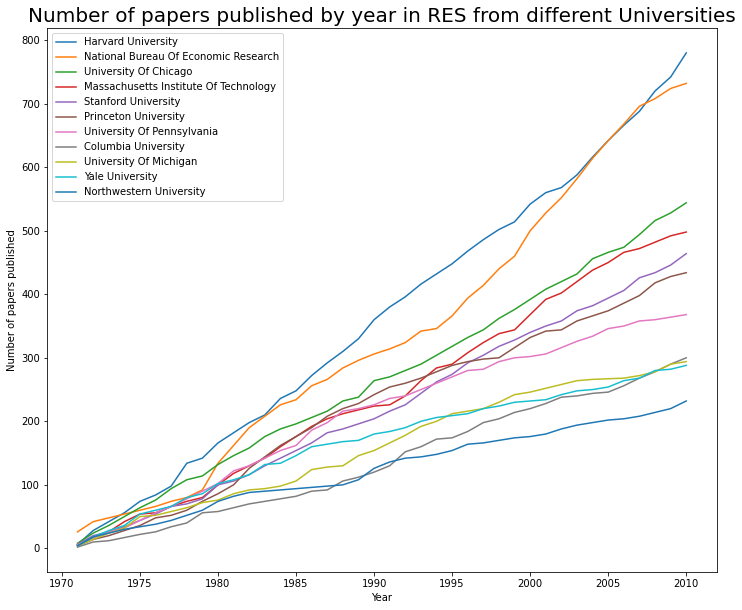

In [ ]:
#Stacked plot on all years
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Combined_cumcount = RES_melted_master
print(Combined_cumcount.head())

a = Combined_cumcount.loc[(Combined_cumcount['Affiliation'] == highest_vals_10.iat[0,2])].drop_duplicates(subset = ['year'], keep = 'last')
b = Combined_cumcount.loc[(Combined_cumcount['Affiliation'] == highest_vals_10.iat[1,2])].drop_duplicates(subset = ['year'], keep = 'last')
c = Combined_cumcount.loc[(Combined_cumcount['Affiliation'] == highest_vals_10.iat[2,2])].drop_duplicates(subset = ['year'], keep = 'last')
d = Combined_cumcount.loc[(Combined_cumcount['Affiliation'] == highest_vals_10.iat[3,2])].drop_duplicates(subset = ['year'], keep = 'last')
e = Combined_cumcount.loc[(Combined_cumcount['Affiliation'] == highest_vals_10.iat[4,2])].drop_duplicates(subset = ['year'], keep = 'last')
f = Combined_cumcount.loc[(Combined_cumcount['Affiliation'] == highest_vals_10.iat[5,2])].drop_duplicates(subset = ['year'], keep = 'last')
g = Combined_cumcount.loc[(Combined_cumcount['Affiliation'] == highest_vals_10.iat[6,2])].drop_duplicates(subset = ['year'], keep = 'last')
h = Combined_cumcount.loc[(Combined_cumcount['Affiliation'] == highest_vals_10.iat[7,2])].drop_duplicates(subset = ['year'], keep = 'last')
i = Combined_cumcount.loc[(Combined_cumcount['Affiliation'] == highest_vals_10.iat[8,2])].drop_duplicates(subset = ['year'], keep = 'last')
j = Combined_cumcount.loc[(Combined_cumcount['Affiliation'] == highest_vals_10.iat[9,2])].drop_duplicates(subset = ['year'], keep = 'last')
k = Combined_cumcount.loc[(Combined_cumcount['Affiliation'] == highest_vals_10.iat[10,2])].drop_duplicates(subset = ['year'], keep = 'last')


plt.figure(figsize=(12,10))
plt.plot(a['year'],a['aff_cum_counts'], label = highest_vals_10.iat[0,2])
plt.plot(b['year'],b['aff_cum_counts'], label = highest_vals_10.iat[1,2])
plt.plot(c['year'],c['aff_cum_counts'], label = highest_vals_10.iat[2,2])
plt.plot(d['year'],d['aff_cum_counts'], label = highest_vals_10.iat[3,2])
plt.plot(e['year'],e['aff_cum_counts'], label = highest_vals_10.iat[4,2])
plt.plot(f['year'],f['aff_cum_counts'], label = highest_vals_10.iat[5,2])
plt.plot(g['year'],g['aff_cum_counts'], label = highest_vals_10.iat[6,2])
plt.plot(h['year'],h['aff_cum_counts'], label = highest_vals_10.iat[7,2])
plt.plot(i['year'],i['aff_cum_counts'], label = highest_vals_10.iat[8,2])
plt.plot(j['year'],j['aff_cum_counts'], label = highest_vals_10.iat[9,2])
plt.plot(k['year'],k['aff_cum_counts'], label = highest_vals_10.iat[10,2])

plt.title('Number of papers published by year in RES from different Universities', fontsize=20)
plt.xlabel('Year')
plt.ylabel('Number of papers published')

plt.legend()
plt.show()